In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from geopy import distance

from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon


In [2]:
df_train = pd.read_csv('data/mf_geo_train.csv')
df_test = pd.read_csv('data/mf_geo_test.csv')

In [3]:
df_train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704
421,uNw6t6xk,37.586825,55.794233,-0.002397
422,Ap42ei8k,37.678790,55.772910,-0.910019
423,rn9A8r62,37.752130,55.619640,-0.326547


In [4]:
df_train.describe()

,lon,lat,target
count,425.000000,425.000000,425.000000
mean,45.466265,55.986388,0.009146
std,16.778159,2.734334,0.979238
min,29.765540,47.208802,-1.428660
25%,37.486227,55.609839,-0.650698
50%,37.707080,55.789394,-0.196887
75%,50.173675,56.350323,0.386584
max,93.023803,60.093366,7.215360


Загружаем карты областей, данные взяты с сайта https://mydata.biz/ru/catalog/databases/borders_ru 

In [5]:
# Rus = gpd.read_file('data/Адм-территориальные границы РФ в формате GeoJSON/regions.geojson')
# Okruga = gpd.read_file('data/Адм-территориальные границы РФ в формате GeoJSON/admin_level_3.geojson')
Oblasti = gpd.read_file('data/Адм-территориальные границы РФ в формате GeoJSON/admin_level_4.geojson')
# Raioni = gpd.read_file('data/Адм-территориальные границы РФ в формате GeoJSON/admin_level_6.geojson')
# Moskou_Piter_raioni = gpd.read_file('data/Адм-территориальные границы РФ в формате GeoJSON/admin_level_8.geojson')


In [6]:
Oblasti.name.sort_values()[(Oblasti.name.sort_values() >= 'Моск')].head(5)

64                       Москва
63           Московская область
2            Мурманская область
36    Ненецкий автономный округ
46        Нижегородская область
Name: name, dtype: object

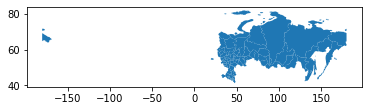

In [7]:
Oblasti.plot()

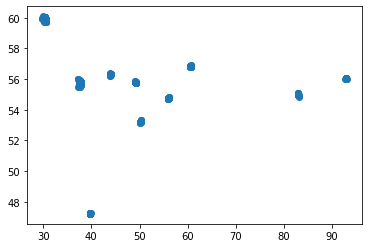

In [8]:
plt.scatter(df_train.lon,df_train.lat)

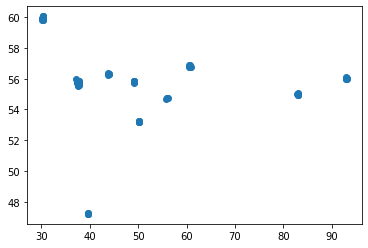

In [9]:
plt.scatter(df_test.lon,df_test.lat)

По распределению видно, что у нас 10 явно выраженных городов

In [10]:
df_train_geo = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train.lon, df_train.lat))
df_test_geo = gpd.GeoDataFrame(df_test, geometry=gpd.points_from_xy(df_test.lon, df_test.lat))

In [11]:
df_itog = gpd.sjoin(df_train_geo, Oblasti[['name','geometry']], op='within')
df_test_itog = gpd.sjoin(df_test_geo, Oblasti[['name','geometry']], op='within')

<ipython-input-11-2ea340c72d96>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df_itog = gpd.sjoin(df_train_geo, Oblasti[['name','geometry']], op='within')
<ipython-input-11-2ea340c72d96>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df_test_itog = gpd.sjoin(df_test_geo, Oblasti[['name','geometry']], op='within')


In [12]:
df_itog.drop('index_right', axis = 1,inplace = True)
df_test_itog.drop('index_right', axis = 1,inplace = True)

In [13]:
# df_Moscow_Piter = gpd.sjoin(df_itog, Moskou_Piter_raioni[['name','geometry']], op='within')
# df_Moscow_Piter_test = gpd.sjoin(df_test_itog, Moskou_Piter_raioni[['name','geometry']], op='within')

Считаем средний таргет по областям

In [14]:
for ind in df_itog.name.value_counts().index:
    df_itog.loc[df_itog.name == ind, 'Mean_target'] = df_itog[df_itog.name == ind].target.mean()
    df_test_itog.loc[df_test_itog.name == ind, 'Mean_target'] = df_itog[df_itog.name == ind].target.mean()

In [15]:
df_itog

,point_id,lon,lat,target,geometry,name,Mean_target
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,0.252092
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,0.252092
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,0.252092
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,0.252092
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,0.252092
...,...,...,...,...,...,...,...
384,mZTEZ4bf,50.158969,53.197251,-0.261717,POINT (50.15897 53.19725),Самарская область,0.953248
387,2SKYY79M,50.246331,53.212183,3.239111,POINT (50.24633 53.21218),Самарская область,0.953248
389,ZfB8GmX1,50.188602,53.191244,0.170484,POINT (50.18860 53.19124),Самарская область,0.953248
404,fI0HvX5p,50.225666,53.259281,0.300144,POINT (50.22567 53.25928),Самарская область,0.953248


In [16]:
df_itog.name.unique()

array(['Москва', 'Ростовская область', 'Красноярский край',
       'Санкт-Петербург', 'Башкортостан', 'Татарстан',
       'Свердловская область', 'Нижегородская область',
       'Новосибирская область', 'Самарская область'], dtype=object)

Смотрим распределение магазинов в тестовом и трейновом датасете

Распределение таргета по областям,
ярко зеленые это таргет больше 0, темно синие меньше 0, звездочка это тестовые данные

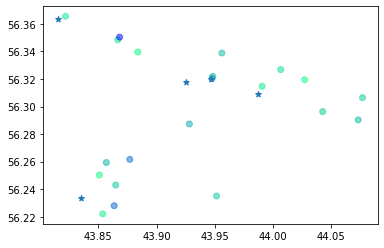

In [16]:
reg = 'Нижегородская область'
plt.figure();

plt.scatter(df_itog[df_itog.name == reg].lon, df_itog[df_itog.name == reg].lat, 
            c = df_itog[df_itog.name == reg].target, cmap = 'winter_r',alpha = 0.5)
plt.scatter(df_test_itog[df_test_itog.name == reg].lon,df_test_itog[df_test_itog.name == reg].lat,marker = '*' )


Распределения таргета в зависимости от региона

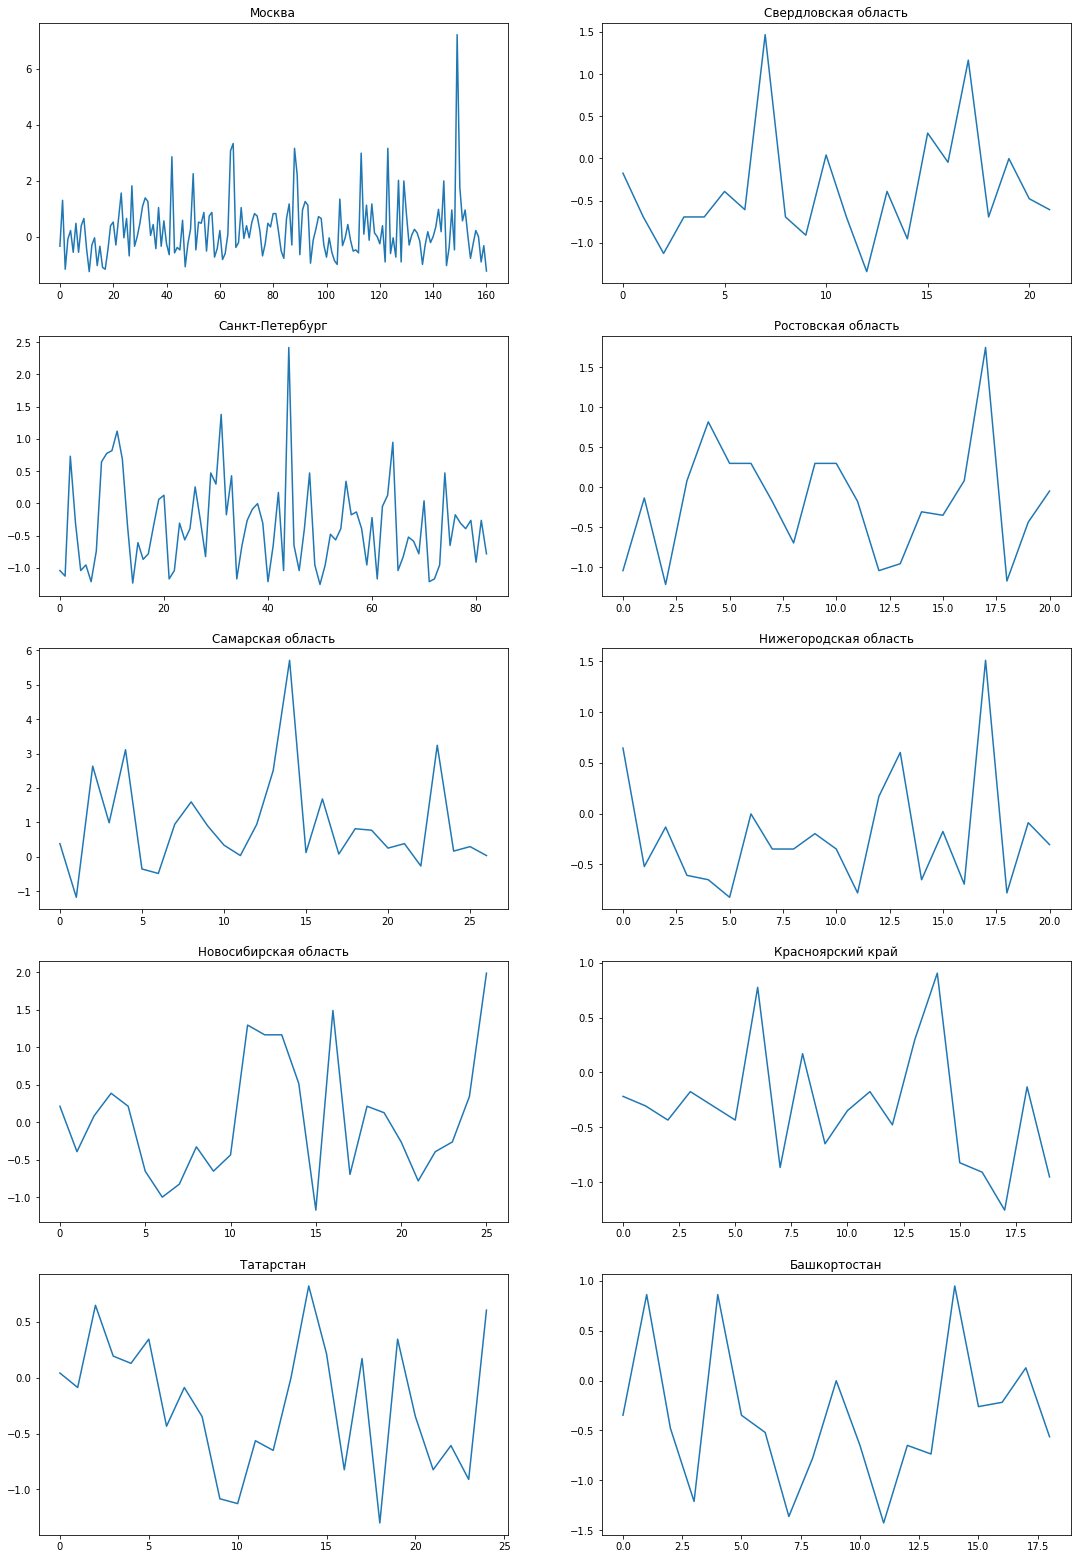

In [17]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(18.5, 10.5)
i = 0
j = 0
plt.subplots_adjust(bottom=0.0, top=2.0)
for ind in df_itog.name.value_counts().index:
    axs[i, j].plot(range(df_itog[df_itog.name == ind].shape[0]),df_itog[df_itog.name == ind].target)
    axs[i, j].set_title(ind)
    if i == 4 :
        j = 1
        i = 0
        continue
    i = i + 1    

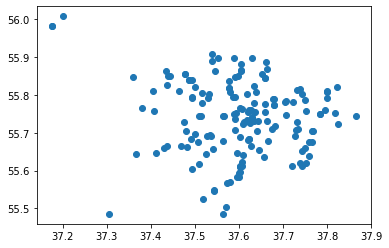

In [18]:
reg = 'Москва'
plt.scatter(df_itog[df_itog.name == reg].lon,df_itog[df_itog.name == reg].lat)

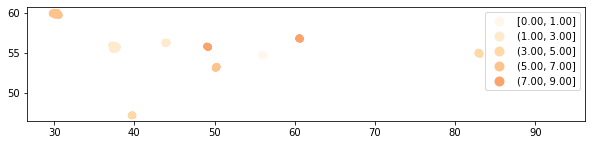

In [19]:
df_itog.plot('name',
           figsize=(10, 15),
           cmap='OrRd', 
           scheme='fisher_jenks',
           legend=True);

Делаем буферну зону вокруг каждой точки

In [17]:
from functools import partial
import pyproj
from shapely.ops import transform

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lon, lat, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf)

In [18]:
df_with_rad = df_itog.copy()
df_with_rad.rename(columns={"geometry": "point_geometry"}, inplace = True)

df_with_rad['geometry'] = df_with_rad.apply(lambda x: geodesic_point_buffer(x['point_geometry'].x, x['point_geometry'].y, 0.5),
                                       axis=1)
df_with_rad.set_geometry('geometry', inplace = True)

In [19]:
df_with_rad_2 = df_itog.copy()
df_with_rad_2.rename(columns={"geometry": "point_geometry"}, inplace = True)

df_with_rad_2['geometry'] = df_with_rad_2.apply(lambda x: geodesic_point_buffer(x['point_geometry'].x, x['point_geometry'].y, 2.0),
                                       axis=1)
df_with_rad_2.set_geometry('geometry', inplace = True)

In [20]:
df_test_with_rad = df_test_itog.copy()
df_test_with_rad.rename(columns={"geometry": "point_geometry"}, inplace = True)

df_test_with_rad['geometry'] = df_test_with_rad.apply(lambda x: geodesic_point_buffer(x['point_geometry'].x, x['point_geometry'].y, 0.5),
                                       axis=1)
df_test_with_rad.set_geometry('geometry', inplace = True)

###  Считаем таргет по ближайшим магазинам

Есть идея создать буферную зону вокруг тестовых магазинов и посчитать среднее количество продаваемых телефонах в магазинах из трейна, которые входят в эту зону

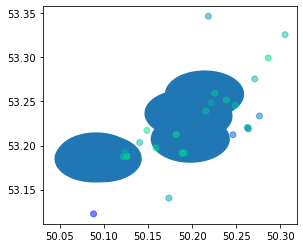

In [336]:
reg = 'Самарская область'
df_test_with_rad[df_test_with_rad.name == reg].geometry.plot()

plt.scatter(df_itog[df_itog.name == reg].lon, df_itog[df_itog.name == reg].lat, 
            c = df_itog[df_itog.name == reg].target, cmap = 'winter_r',alpha = 0.5)

In [25]:
df_perem = df_with_rad.copy()
df_perem.rename(columns={"target": "target_isnach"}, inplace = True)
df_perem.drop(columns = 'point_geometry', inplace = True)


In [26]:
df_perem = gpd.sjoin(df_perem, df_itog[['target', 'geometry']], op='contains')

Делаем маску на магазины в буферную зону которых никто не вошел, далее им будем присваивать среднее значение по городу

In [27]:
mask = (df_perem.groupby('point_id')['target'].count().reset_index().sort_values(by = 'point_id').target != 1)

In [28]:
df_target_3 = df_perem.groupby('point_id')['target'].mean().reset_index().sort_values(by = 'point_id')[mask]

In [29]:
df_perem.drop(columns = ['index_right','target','Mean_target'] , inplace = True)

In [30]:
df_perem = df_perem.drop_duplicates()

In [31]:
df_perem = df_perem.merge(df_target_3, on=['point_id'], how = 'inner')

In [32]:
df_perem = df_perem.merge(df_itog[['point_id','Mean_target','target']], on=['point_id'], how = 'outer')

In [33]:
df_perem.target_x.fillna(df_perem.Mean_target, inplace= True)

In [34]:
mean_absolute_error(df_perem.target_y, df_perem.target_x)

0.5398576880389294

Ошибка:

    0.54 для зоны из 3км 392 - магазина

    0.506 для зоны из 2км 345 - магазина

    Для всех магазинов(даже для тех, у кого нет соседей, для таких просто заменяем средним по городу)

    0.55 для 1.5км

    0.54 для 2 км

    0.55 для 2.5 км

    0.57 для 3 км

Проделываем тоже с тестом на 2км

In [35]:
df_test_perem = df_test_with_rad.copy()
df_test_perem.drop(columns = ['point_geometry','target'], inplace = True)

df_test_perem = gpd.sjoin(df_test_perem, df_itog[['target', 'geometry']], op='contains')

df_test_target_3 = df_test_perem.groupby('point_id')['target'].mean().reset_index().sort_values(by = 'point_id')

df_test_perem.drop(columns = ['index_right'] , inplace = True)

df_test_perem = df_test_perem.drop_duplicates(subset = 'point_id')
df_test_perem.drop(columns = ['target','Mean_target'], inplace = True)

df_test_perem = df_test_perem.merge(df_test_target_3, on=['point_id'], how = 'inner')
df_test_perem = df_test_perem.merge(df_test_with_rad[['point_id','Mean_target']], on=['point_id'], how = 'outer')
df_test_perem.target.fillna(df_test_perem.Mean_target, inplace= True)

In [37]:
# submission = df_test_perem[['point_id','target']]
# submission.to_csv('Predictions/pred(3km)only-target.csv', index=False)

0.69 для 2км на лидерборде
0.72 для 3

Метод в итоге оказался интересным, на кегле показал скор 0.68, что весьма неплохо, но очевидно что такой метод упускает огромное кол-во информации. Поэтому будем пытаться решать другими способами.

### Загружаю данные из ОМС

Для 5 фичей у объектов будем использовать: вокзалы, рестораны, автобусные станции, школы, и дома 

Так как территория между всеми магазина ограмная, то не имееет смысла скачивать данные по всей России, поэтому будем ориентироваться по городам(10 штук).

Для каждого города создадим ситибокс и будем скачивать данные отдельно по каждому городу.

### Функции

Делаю сити бокс, в зависимости от названия города по максимальному и манимальному значению широты и долго ты точек в этом городе

In [21]:
def city_box(name):
# берем облатсь чуть больше(примерно на 2.5км по каждой координате), чтобы у каждой точки была буферная зона
    lon_max = df_itog[df_itog.name == name].lon.max() + 0.7
    lon_min = df_itog[df_itog.name == name].lon.min() - 0.7

    lat_max = df_itog[df_itog.name == name].lat.max() + 0.7
    lat_min = df_itog[df_itog.name == name].lat.min() - 0.7


    m_bbox = lat_min,lon_min,lat_max,lon_max
    return m_bbox

Функция нахождения ближайшей станции

In [72]:
def railway_distance(df,name):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = '''
    [out:json];
    (node['railway' = 'station']({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()

    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
        pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm
    dist = []
    for point in df.point_id:
        a = []
        point_coord = df[df.point_id==point].lat.values, df[df.point_id==point].lon.values
        for i in range(amenity_osm.shape[0]):
            station_coord = amenity_osm.iloc[i].lat,amenity_osm.iloc[i].lon
            a.append(distance.geodesic(point_coord,station_coord).m)
        dist.append(np.array(a).min())
    return(dist)

### Загружаю по 5 фичей для каждого района

вокзалы, рестораны, автобусные станции, школы, и дома 

In [95]:
def amenity_railway(df,name):
    overpass_query = '''
    [out:json];
    (
    node['railway' = 'station']({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))
    response = requests.get(overpass_url,
    params={'data': overpass_query})
    amenity = response.json()
    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df[['point_id', 'geometry']], op='within')
    amenity_osm = amenity_osm.groupby(['point_id']).size().reset_index()
    amenity_osm.columns = ['point_id', 'Number_stations']
    return pd.merge(df[df.name == name],amenity_osm, on = 'point_id')

In [90]:
def amenity_transport(df,name):
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = '''
    [out:json];
    (node["public_transport" = "station"]({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()
    
    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df[['point_id', 'geometry']], op='within')
    amenity_osm = amenity_osm.groupby(['point_id']).size().reset_index()
    amenity_osm.columns = ['point_id', 'Number_bus_stations']
    return pd.merge(df[df.name == name],amenity_osm, on = 'point_id')

In [91]:
def amenity_school(df,name):
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = '''
    [out:json];
    (node["amenity" = 'school']({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()
    
    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df[['point_id', 'geometry']], op='within')
    amenity_osm = amenity_osm.groupby(['point_id']).size().reset_index()
    amenity_osm.columns = ['point_id', 'Number_schools']
    return pd.merge(df[df.name == name],amenity_osm, on = 'point_id')

In [92]:
def amenity_restaurant(df,name):
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = '''
    [out:json];
    (node["amenity" = "restaurant"]({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()
    
    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df[['point_id', 'geometry']], op='within')
    amenity_osm = amenity_osm.groupby(['point_id']).size().reset_index()
    amenity_osm.columns = ['point_id', 'Number_restaurant']
    return pd.merge(df[df.name == name],amenity_osm, on = 'point_id')

In [93]:
def amenity_building(df, name):
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = '''
    [out:json];
    (node["building"]({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()

    
    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df[['point_id', 'geometry']], op='within')
    amenity_osm = amenity_osm.groupby(['point_id']).size().reset_index()
    amenity_osm.columns = ['point_id', 'Number_building']
    return pd.merge(df[df.name == name],amenity_osm, on = 'point_id')

### Берем топ 30 аменити в районе 500 метров

In [78]:
def amenity_all(name):
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = '''
    [out:json];
    (node["amenity"]({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()

    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df_with_rad[['point_id', 'geometry']], op='within')
    top30_amenity = amenity_osm.amenity.value_counts()[:30].index
    amenity_osm = amenity_osm[amenity_osm.amenity.isin(top30_amenity)]
    amenity_osm = amenity_osm.groupby(['point_id', 'amenity']).size().unstack(fill_value=0).reset_index()
    return  pd.merge(df_with_rad[df_with_rad.name == name],amenity_osm, on = 'point_id')



In [79]:
def amenity_all_test(name):
    overpass_url = "http://overpass-api.de/api/interpreter"

    overpass_query = '''
    [out:json];
    (
    node["amenity"]({},{},{},{});
    );
    out center;
    '''.format(*city_box(name))

    response = requests.get(overpass_url, 
                             params={'data': overpass_query})
    amenity = response.json()

    amenity_osm = pd.DataFrame(amenity['elements'])
    amenity_osm = pd.concat([amenity_osm,
         pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
    amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
    amenity_osm = gpd.GeoDataFrame(amenity_osm)
    amenity_osm = gpd.sjoin(amenity_osm, df_test_with_rad[['point_id', 'geometry']], op='within')
    top30_amenity = amenity_osm.amenity.value_counts()[:30].index
    amenity_osm = amenity_osm[amenity_osm.amenity.isin(top30_amenity)]
    amenity_osm = amenity_osm.groupby(['point_id', 'amenity']).size().unstack(fill_value=0).reset_index()
    return  pd.merge(df_test_with_rad[df_test_with_rad.name == name],amenity_osm, on = 'point_id')

In [80]:
# overpass_url = "http://overpass-api.de/api/interpreter"

# overpass_query = '''
# [out:json];
# (
# node['building']({},{},{},{});
# );
# out center;
# '''.format(*city_box('Свердловская область'))

# response = requests.get(overpass_url, 
#                          params={'data': overpass_query})
# amenity = response.json()

# amenity_osm = pd.DataFrame(amenity['elements'])
# amenity_osm = pd.concat([amenity_osm,
#     pd.DataFrame([x['tags'] for x in amenity['elements']])], axis=1).drop('tags', axis=1)
# amenity_osm['geometry'] = [Point(x,y) for x,y in zip(amenity_osm.lon, amenity_osm.lat)]
# amenity_osm = gpd.GeoDataFrame(amenity_osm)

In [81]:
# amenity_osm = gpd.sjoin(amenity_osm, df_test_with_rad[['point_id', 'geometry']], op='within')

In [82]:
# df_test_with_rad[df_test_with_rad.name =='Свердловская область'].plot()

In [83]:
# df_test_with_rad[df_test_with_rad.name =='Свердловская область']

In [84]:
# top30_amenity = amenity_osm.amenity.value_counts()[:30].index
# amenity_osm = amenity_osm[amenity_osm.amenity.isin(top30_amenity)]

In [85]:
# amenity_osm = amenity_osm.groupby(['point_id', 'amenity']).size().unstack(fill_value=0).reset_index()

In [60]:
# pd.merge(df_test_with_rad[df_test_with_rad.name == 'Свердловская область'],amenity_osm, on = 'point_id')

###  Ближайшие станции железной дороги

In [120]:
df_dis = df_itog.copy()
dist = []
for i, ind in enumerate(df_itog.name.value_counts().index):
    df_dis.loc[df_dis.name == ind, 'railway_dist'] = railway_distance(df_dis.loc[df_dis.name == ind], ind)

In [130]:
df_dis

,point_id,lon,lat,target,geometry,name,Mean_target,railway_dist
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,0.252092,159.413308
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,0.252092,176.055443
3,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,0.252092,59.407885
4,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,0.252092,221.826970
7,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,0.252092,283.762220
...,...,...,...,...,...,...,...,...
384,mZTEZ4bf,50.158969,53.197251,-0.261717,POINT (50.15897 53.19725),Самарская область,0.953248,626.892063
387,2SKYY79M,50.246331,53.212183,3.239111,POINT (50.24633 53.21218),Самарская область,0.953248,94.277497
389,ZfB8GmX1,50.188602,53.191244,0.170484,POINT (50.18860 53.19124),Самарская область,0.953248,1289.490296
404,fI0HvX5p,50.225666,53.259281,0.300144,POINT (50.22567 53.25928),Самарская область,0.953248,5039.290026


In [137]:
df_dis_test = df_test_itog.copy()
dist = []
for i, ind in enumerate(df_dis_test.name.value_counts().index):
    df_dis_test.loc[df_dis_test.name == ind, 'railway_dist'] = railway_distance(df_dis_test.loc[df_dis_test.name == ind], ind)

In [138]:
df_dis_test

,point_id,lon,lat,target,geometry,name,Mean_target,railway_dist
0,F4lXR1cG,37.681242,55.748040,0.0091,POINT (37.68124 55.74804),Москва,0.252092,162.889889
2,kLuAAN3s,37.598614,55.781357,0.0091,POINT (37.59861 55.78136),Москва,0.252092,166.484905
3,OxQHvaNu,37.794051,55.717468,0.0091,POINT (37.79405 55.71747),Москва,0.252092,54.264453
5,7x7uZwPc,37.617141,55.795433,0.0091,POINT (37.61714 55.79543),Москва,0.252092,52.988755
7,OMCMewkC,37.798028,55.810580,0.0091,POINT (37.79803 55.81058),Москва,0.252092,143.405756
...,...,...,...,...,...,...,...,...
39,WRf9qCgC,93.015521,55.988184,0.0091,POINT (93.01552 55.98818),Красноярский край,-0.315742,4144.512145
72,2VNvJAyN,92.932816,56.002145,0.0091,POINT (92.93282 56.00214),Красноярский край,-0.315742,1246.945092
95,9um9WSSk,92.950129,55.995629,0.0091,POINT (92.95013 55.99563),Красноярский край,-0.315742,328.323024
103,4nmfqUw0,92.928927,56.116262,0.0091,POINT (92.92893 56.11626),Красноярский край,-0.315742,4489.266682


### Скачиваю данные с помощью функций для 5 типов объектов

Изначально я сохраню все данные для заданий, потом буду строить для каждого набора модели

Объединяем 5 наших фичей

Скачиваю я данные отдельно для каждого города(10 городов)

In [96]:
df_with_railway = [0,0,0,0,0,0,0,0,0,0]
df_with_transport = [0,0,0,0,0,0,0,0,0,0]
df_with_restaurant = [0,0,0,0,0,0,0,0,0,0]
df_with_school = [0,0,0,0,0,0,0,0,0,0]
df_with_building = [0,0,0,0,0,0,0,0,0,0]

for i, ind in enumerate(df_itog.name.value_counts().index):
    df_with_railway[i] = amenity_railway(df_with_rad,ind)
    df_with_transport[i] = amenity_transport(df_with_rad,ind)
    df_with_restaurant[i] = amenity_restaurant(df_with_rad,ind)
    df_with_school[i] = amenity_school(df_with_rad,ind)
    df_with_building[i] = amenity_building(df_with_rad,ind)
# pd.concat(df_with_amenity)   

In [97]:
df_railway = pd.concat(df_with_railway)
df_railway.fillna(0,inplace = True)
df_transport = pd.concat(df_with_transport)
df_transport.fillna(0,inplace = True)
df_restaurant = pd.concat(df_with_restaurant)
df_restaurant.fillna(0,inplace = True)
df_school = pd.concat(df_with_school)
df_school.fillna(0,inplace = True)
df_builing = pd.concat(df_with_building)
df_builing.fillna(0,inplace = True)

In [98]:
df_itog_with5 = df_itog.copy()

In [99]:
df_itog_with5 = pd.merge(df_itog_with5, df_railway[['point_id', 'Number_stations']], on = 'point_id', how = 'left')
df_itog_with5 = pd.merge(df_itog_with5, df_transport[['point_id', 'Number_bus_stations']], on = 'point_id', how = 'left')
df_itog_with5 = pd.merge(df_itog_with5, df_restaurant[['point_id', 'Number_restaurant']], on = 'point_id', how = 'left')
df_itog_with5 = pd.merge(df_itog_with5, df_school[['point_id', 'Number_schools']], on = 'point_id', how = 'left')
df_itog_with5 = pd.merge(df_itog_with5, df_builing[['point_id', 'Number_building']], on = 'point_id', how = 'left')
df_itog_with5.fillna(0,inplace = True)

In [103]:
df_itog_with5

,point_id,lon,lat,target,geometry,name,Mean_target,Number_stations,Number_bus_stations,Number_restaurant,Number_schools,Number_building
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,0.252092,2.0,1.0,0.0,0.0,1.0
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,0.252092,1.0,0.0,0.0,0.0,8.0
2,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,0.252092,1.0,1.0,4.0,0.0,1.0
3,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,0.252092,3.0,1.0,19.0,0.0,3.0
4,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,0.252092,1.0,1.0,3.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420,mZTEZ4bf,50.158969,53.197251,-0.261717,POINT (50.15897 53.19725),Самарская область,0.953248,0.0,0.0,0.0,0.0,0.0
421,2SKYY79M,50.246331,53.212183,3.239111,POINT (50.24633 53.21218),Самарская область,0.953248,1.0,0.0,0.0,0.0,1.0
422,ZfB8GmX1,50.188602,53.191244,0.170484,POINT (50.18860 53.19124),Самарская область,0.953248,0.0,0.0,2.0,0.0,0.0
423,fI0HvX5p,50.225666,53.259281,0.300144,POINT (50.22567 53.25928),Самарская область,0.953248,0.0,0.0,1.0,0.0,0.0


Так же для теста

In [100]:
df_with_railway_test = [0,0,0,0,0,0,0,0,0,0]
df_with_transport_test = [0,0,0,0,0,0,0,0,0,0]
df_with_restaurant_test = [0,0,0,0,0,0,0,0,0,0]
df_with_school_test = [0,0,0,0,0,0,0,0,0,0]
df_with_building_test = [0,0,0,0,0,0,0,0,0,0]

df_with_railway_test = [0,0,0,0,0,0,0,0,0,0]
for i, ind in enumerate(df_itog.name.value_counts().index):
    df_with_railway_test[i] = amenity_railway(df_test_with_rad,ind)
    df_with_transport_test[i] = amenity_transport(df_test_with_rad,ind)
    df_with_restaurant_test[i] = amenity_restaurant(df_test_with_rad,ind)
    df_with_school_test[i] = amenity_school(df_test_with_rad,ind)
    df_with_building_test[i] = amenity_building(df_test_with_rad,ind)
# pd.concat(df_with_amenity)   

In [101]:
df_railway_test = pd.concat(df_with_railway_test)
df_railway_test.fillna(0,inplace = True)
df_transport_test = pd.concat(df_with_transport_test)
df_transport_test.fillna(0,inplace = True)
df_restaurant_test = pd.concat(df_with_restaurant_test)
df_restaurant_test.fillna(0,inplace = True)
df_school_test = pd.concat(df_with_school_test)
df_school_test.fillna(0,inplace = True)
df_builing_test = pd.concat(df_with_building_test)
df_builing_test.fillna(0,inplace = True)

In [102]:
df_itog_with5_test = df_test_itog.copy()
df_itog_with5_test = pd.merge(df_itog_with5_test, df_railway_test[['point_id', 'Number_stations']], on = 'point_id', how = 'left')
df_itog_with5_test = pd.merge(df_itog_with5_test, df_transport_test[['point_id', 'Number_bus_stations']], on = 'point_id', how = 'left')
df_itog_with5_test = pd.merge(df_itog_with5_test, df_restaurant_test[['point_id', 'Number_restaurant']], on = 'point_id', how = 'left')
df_itog_with5_test = pd.merge(df_itog_with5_test, df_school_test[['point_id', 'Number_schools']], on = 'point_id', how = 'left')
df_itog_with5_test = pd.merge(df_itog_with5_test, df_builing_test[['point_id', 'Number_building']], on = 'point_id', how = 'left')
df_itog_with5_test.fillna(0,inplace = True)

In [104]:
df_itog_with5_test

,point_id,lon,lat,target,geometry,name,Mean_target,Number_stations,Number_bus_stations,Number_restaurant,Number_schools,Number_building
0,F4lXR1cG,37.681242,55.748040,0.0091,POINT (37.68124 55.74804),Москва,0.252092,2.0,2.0,3.0,0.0,2.0
1,kLuAAN3s,37.598614,55.781357,0.0091,POINT (37.59861 55.78136),Москва,0.252092,2.0,0.0,30.0,0.0,6.0
2,OxQHvaNu,37.794051,55.717468,0.0091,POINT (37.79405 55.71747),Москва,0.252092,1.0,1.0,2.0,0.0,1.0
3,7x7uZwPc,37.617141,55.795433,0.0091,POINT (37.61714 55.79543),Москва,0.252092,1.0,0.0,5.0,0.0,1.0
4,OMCMewkC,37.798028,55.810580,0.0091,POINT (37.79803 55.81058),Москва,0.252092,1.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102,WRf9qCgC,93.015521,55.988184,0.0091,POINT (93.01552 55.98818),Красноярский край,-0.315742,0.0,0.0,0.0,0.0,0.0
103,2VNvJAyN,92.932816,56.002145,0.0091,POINT (92.93282 56.00214),Красноярский край,-0.315742,0.0,0.0,0.0,0.0,0.0
104,9um9WSSk,92.950129,55.995629,0.0091,POINT (92.95013 55.99563),Красноярский край,-0.315742,1.0,0.0,0.0,0.0,0.0
105,4nmfqUw0,92.928927,56.116262,0.0091,POINT (92.92893 56.11626),Красноярский край,-0.315742,0.0,0.0,0.0,0.0,0.0


### Скачиваю данные для 30 наиболее частых аменити в буферной зоне

Объединяем по 30 аменити 500 метровая зона

In [105]:
df_with_amenity = [0,0,0,0,0,0,0,0,0,0]
df_with_amenity_test = [0,0,0,0,0,0,0,0,0,0]
for i, ind in enumerate(df_itog.name.value_counts().index):
    df_with_amenity[i] = amenity_all(ind)
    df_with_amenity_test[i] = amenity_all_test(ind)
# pd.concat(df_with_amenity)   

In [106]:
df_all_amenity = pd.concat(df_with_amenity)
df_all_amenity.fillna(0,inplace = True)

In [107]:
df_all_amenity_test = pd.concat(df_with_amenity_test)
df_all_amenity_test.fillna(0,inplace = True)

In [108]:
amenity = []
for i  in df_all_amenity.columns.values:
    if sum(df_all_amenity_test.columns == i) > 0:
          amenity.append(i)

In [109]:
df_all_amenity = df_all_amenity[amenity]

In [111]:
df_all_amenity

,point_id,lon,lat,target,point_geometry,name,Mean_target,geometry,atm,bank,...,water_point,community_centre,college,public_service,university,bus_station,clock,shelter,social_facility,theatre
0,ommNZCUV,37.590776,55.848630,-0.348157,POINT (37.59078 55.84863),Москва,0.252092,"POLYGON ((37.59876 55.84863, 37.59872 55.84819...",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nMe2LHPb,37.784210,55.750271,1.294206,POINT (37.78421 55.75027),Москва,0.252092,"POLYGON ((37.79217 55.75027, 37.79213 55.74983...",5,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0t2jNYdz,37.704570,55.782020,-1.169339,POINT (37.70457 55.78202),Москва,0.252092,"POLYGON ((37.71254 55.78202, 37.71250 55.78158...",7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,U27W4QJ7,37.643983,55.730188,-0.088837,POINT (37.64398 55.73019),Москва,0.252092,"POLYGON ((37.65194 55.73019, 37.65190 55.72975...",18,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CO76tdVs,37.444304,55.850511,0.213704,POINT (37.44430 55.85051),Москва,0.252092,"POLYGON ((37.45229 55.85051, 37.45225 55.85007...",7,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,ySZshzYS,55.999586,54.749739,0.948446,POINT (55.99959 54.74974),Башкортостан,-0.356119,"POLYGON ((56.00735 54.74974, 56.00731 54.74930...",2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,m41j6rrW,56.010003,54.759041,-0.261717,POINT (56.01000 54.75904),Башкортостан,-0.356119,"POLYGON ((56.01777 54.75904, 56.01773 54.75860...",5,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,5e7r5h7s,55.931315,54.674806,-0.218497,POINT (55.93132 54.67481),Башкортостан,-0.356119,"POLYGON ((55.93907 54.67481, 55.93903 54.67437...",1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,6FdFnHvc,56.034734,54.789618,0.127264,POINT (56.03473 54.78962),Башкортостан,-0.356119,"POLYGON ((56.04251 54.78962, 56.04247 54.78918...",0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [110]:
df_all_amenity_test = df_all_amenity_test[amenity]

### Строим модели для наших данных

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

In [202]:
# pd.get_dummies(df_test_itog.drop(['point_id','target','geometry'], axis=1))

Соединим наши 5 фичей и дистанцию до вокзала

In [129]:
df_itog_with5 = pd.merge(df_itog_with5,df_dis[['railway_dist', 'point_id']], on = 'point_id')

In [139]:
df_itog_with5_test = pd.merge(df_itog_with5_test,df_dis_test[['railway_dist', 'point_id']], on = 'point_id')

In [132]:
# X_strat = df_all_amenity.drop(['point_id','target','geometry','point_geometry','name'], axis=1)
# X_all = df_all_amenity.drop(['point_id','target','geometry','point_geometry','name'], axis=1)
X_all = df_itog_with5.drop(['point_id', 'geometry', 'target'], axis=1)
y_all = df_itog_with5['target']

le = LabelEncoder()
X_all['name'] = le.fit_transform(X_all.values[:, 2])

X_test = df_itog_with5_test.drop(['point_id', 'geometry', 'target'], axis=1)

X_test['name'] = le.transform(X_test.values[:, 2])

In [133]:
model = RandomForestRegressor()
model.fit(X_all, y_all)

RandomForestRegressor()

In [134]:
-1 * cross_val_score(model, X_all, y_all, cv=20, scoring='neg_mean_absolute_error').mean()

0.7110059970253524

In [1019]:
X_test['target'] = model.predict(X_test)

In [1023]:
X_test['point_id'] = df_itog_with5_test.point_id

Линейная регрессия дает неплохой скор, но так как у нас есть категориальные фичи(имя города), то лучше использовать другой метод.

Я выбрал RandomForest

Более менее сбалансированно

In [1025]:
# skf = StratifiedKFold(n_splits=10)
# er = []
# for train, test in skf.split(X_all, X_all['name']):
#     model = LinearRegression()
#     model.fit(X_all.loc[train].drop(columns='name'), y_all.loc[train])
#     er.append(mean_absolute_error(y_all.loc[test], model.predict(X_all.loc[test].drop(columns='name'))))
# np.mean(er)

In [83]:
# -1 * cross_val_score(model, X_all, y_all, cv=20, scoring='neg_mean_absolute_error').mean()

### Итоговое решение

При построениии моделей я решил, что будет лучше если для каждого города будет своя модель:

    1)Так, как город сильно влияет на значение тагрета
    2)Так, как такой метод дал лучший скор на кегле

In [122]:
import xgboost as xgb

In [142]:
import warnings
warnings.filterwarnings("ignore")

Тут я избавился от 2 строк, которые сильно выделялись на общем фоне, скор на кросс-валидации улучшился на 0.03

In [135]:
df_itog_with5 = df_itog_with5.loc[-(df_itog_with5.target > 5)]

Строю модели для каждого из 10 городов и сразу предсказываю на нем тест, по 5 фичам(вокзалы, рестораны, автобусные станции, школы, и дома), так же широте и долготе

In [143]:
df_city = [0,0,0,0,0,0,0,0,0,0]
df_test_city = [0,0,0,0,0,0,0,0,0,0]
score_test = []
score = []
df_encod = df_itog_with5.copy()
# df_encod = df_encod.loc[-(df_encod.target > 5)]
# le = LabelEncoder()
# df_encod['name'] = le().fit_transform(df_encod.values[:, 5])
df_test_encod = df_itog_with5_test.copy()
# df_test_encod['name'] = le().transform(df_test_encod.values[:, 5])
for i, ind in enumerate(df_encod.name.value_counts().index):
    df_city[i] = df_encod[df_encod.name == ind]
    model = RandomForestRegressor()
    model.fit(df_city[i].drop(['point_id', 'target', 'geometry', 'name', 'Mean_target'], axis = 1),
              df_city[i]['target'])
    df_test_city[i] = df_test_encod[df_test_encod.name == ind]
    score_test.append(model.predict(df_test_city[i].drop(['point_id', 'target', 'geometry', 'name', 'Mean_target'], axis = 1)))
    df_test_city[i]['target'] = score_test[i]
    score.append((-1 * cross_val_score(model, df_city[i].drop(['point_id', 'target', 'geometry', 'name', 'Mean_target'], axis = 1), 
                                       df_city[i]['target'],
                                       cv=10, scoring='neg_mean_absolute_error').mean()))
df_test_city = pd.concat(df_test_city) 
sum(score)/10


0.6427775864869391

In [144]:
score

[0.7864072219064155,
 0.5360363518242703,
 0.7905676064458036,
 0.8401338542813717,
 0.5672977480773039,
 0.6055927949112089,
 0.5710131156880373,
 0.5875772178385805,
 0.5398406207732835,
 0.6033093331231149]

Предсказание раздельно по 10 городам, 0.61 на лидерборде

Самое смешно, что при удалении этих выбросов, скор на кросс валидации уменьшается на 0.03, но при этом паблике кегла скор ухадшился на 0.1, и стал 0.71.

Для разных зоны были такие результаты нв Кегле:

    После предсказания по 5 аменити скор 0.71 на кегле для 100 метров

    После предсказания по 5 аменити скор 0.65 на кегле для 500 метров

    После предсказания по 5 аменити скор 0.68 на кегле для 1000 метров
    
    При добавлении растояния до ближайшей станции скор сильно не поменялся
   

In [147]:
df_all_amenity = df_all_amenity.loc[-(df_all_amenity.target > 5)]

Удалим строки в которых таргет болше 5, они сбивают классификатор

In [148]:
df_city = [0,0,0,0,0,0,0,0,0,0]
df_test_city = [0,0,0,0,0,0,0,0,0,0]
score_test = []
score = []
for i, ind in enumerate(df_all_amenity.name.value_counts().index):
    df_city[i] = df_all_amenity[df_all_amenity.name == ind]
    model = RandomForestRegressor(max_depth=3)
    model.fit(df_city[i].drop(['point_id','target','geometry','point_geometry','name'], axis=1),
              df_city[i]['target'])
    df_test_city[i] = df_all_amenity_test[df_all_amenity_test.name == ind]
    score_test.append(model.predict(df_test_city[i].drop(['point_id','target','geometry','point_geometry','name'], axis=1)))
    df_test_city[i]['target'] = score_test[i]
    score.append((-1 * cross_val_score(model, df_city[i].drop(['point_id','target','geometry','point_geometry','name'], axis=1), 
                                       df_city[i]['target'],
                                       cv=10, scoring='neg_mean_absolute_error').mean()))
    #*len(df_city[i])/425
sum(score)/10
# pd.concat(df_test_city) 
df_test_city = pd.concat(df_test_city)    

Лесом получается неплохо, но как и везде велика ошибка в Москве и в Самаре, удаляем выбросы из нашего датафрема, больше 5.

Когда берем топ 30 аменити скор на паблике 0.67, это лучше скора без аменити (0.71)

### KeplerGl

In [128]:
from keplergl import KeplerGl

In [174]:
df_kepler = df_itog.copy()

Карта Москвы с таргетом, темные точки - высокий таргет

In [161]:
map_1 = KeplerGl()
map_1.add_data(data = df_kepler[df_kepler.name == 'Москва'], name='Target')
map_1.add_data(data = Oblasti[Oblasti['name:ru']== 'Москва'], name='Moscow')

map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Target': {'index': [0, 1, 3, 4, 7, 11, 14, 15, 19, 21, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,…

In [177]:
import json
json_data = map_1.config
with open('Moscow_config.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [171]:
map_1.save_to_html(file_name='Map_Moscow.html')

Map saved to Map_Moscow.html!


Карта Санкт-Петербурга, корчинивые - высокий таргет

In [176]:
map_2 = KeplerGl()
map_2.add_data(data = df_kepler[df_kepler.name == 'Санкт-Петербург'], name='Target')
map_2.add_data(data = Oblasti[Oblasti['name:ru']== 'Санкт-Петербург'], name='Санкт-Петербург')

map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Target': {'index': [6, 20, 22, 42, 43, 49, 53, 57, 64, 70, 71, 75, 78, 84, 96, 98, 101, 104, 1…

In [180]:
import json
json_data = map_2.config
with open('Piter_config.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [181]:
map_2.save_to_html(file_name='Map_Piter.html')

Map saved to Map_Piter.html!


Submission

In [146]:
# submission = df_test[['point_id']]
# submission['target'] = model.predict(pd.get_dummies(df_test_itog.drop(['point_id','target','geometry'], axis=1)))

submission = df_test_city[['point_id','target']]

submission.to_csv('Predictions/pred_5_amenity_dist.csv', index=False)

В итоге:

    Мы определии город для каждого из салонов Мегафона, оказалось 10 городов. Построили графики распределения салонов по этим городам. Выделили буферную зону для каждого магазина. Посчитали для каждого магазина из теста эту буферную зону, взяли значения таргета в ближайших магазинах из трейна и усреднили их, для получения приблизительной оценки предсказания.(см. пункт - Считаем таргет по ближайшим магазинам)
    
    Далее мы загрузили данные из ОSM для каждого города в отдельности, для этого изначально посчитав буферную зону города.По этим данным мы нашли ближайшую железнодорожную станцию к каждому магазину, взяли 5 фичей, которые по-моему мнению лучше всего характеризуют расположение магазина. Так же, загрузили самые популярные аменити для каждого из магазинов, взяв топ 30 из них.
    
    При построении моделей ориентировались на скор на кросс валидации. Так как данные в большинстве случаев случайны, то разбивали на 10 фолдов, для получении максимально корректного результата.
    
    Из-за того, что зависимость от города была большая, было построено 10 различных моделей - для каждого города своя, и тестировались они в цикле по городам.
    
    Лучший скор на паблике Кегла был 0.61, это было для предсказаний с учетом разбиений по каждому городу по широте и долготе, без каких либо фичей, что очень странно. Скорее всего, это связано с тем, что скор на паблике считается по 9% процентам данных с  теста - это примерно 10 пунктов, и при таких условиях просто повезло с сидом, и на этих 10 строках результат был хороший, что очевидно никак не характерихует всю модель в целом. Понятно, что лучше предсказывать по большему количеству фичей, чем широта и долгота. Поэтому были сгенерированны 5 фичей (вокзалы, рестораны, автобусные станции, школы и дома) для каждого магазина, и рассчиатано расстояние, это дало небольшой прирост на кросс валидации.
    
    Лучший скор на кросс валидации был около 0.6, это было при использовании топ 30 самых популярных фичей. Модель брали RandomForest, так как он может обрабатывать как категориальные, так и колличественные переменные. На паблике для таких параментров скор был около 0.65.